# CNNの実装
PyTorchを使って、畳み込みニューラルネットワーク（CNN）を実装します。  
CNN自体はCNNの層を追加するのみで実装可能なのですが、今回はデータ拡張とドロップアウトの実装も行います。


## CIFAR-10
torchvision.datasetsを使い、CIFAR-10を読み込みます。  
CIFARは、約6万枚の画像にラベルをつけたたデータセットです。  
以下のコードでは、CIFAR-10を読み込み、ランダムな25枚の画像を表示します。

Extracting ./data/cifar-10-python.tar.gz to ./data
データの数: 10000



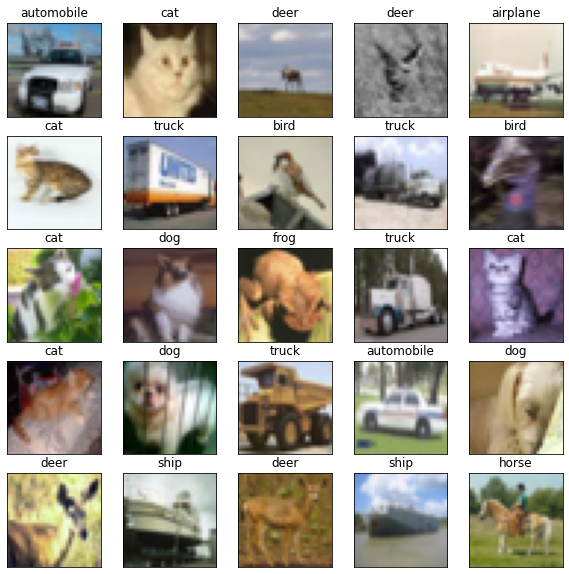

In [2]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms # 画像に変換を加える
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

cifar10_data = CIFAR10(root="./data",
                       train=False,download=True, 
                       transform=transforms.ToTensor()) #train=False：テスト用データとして読み込む # transforms.ToTensor()：Tensorに変換する

cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer",
                            "dog", "frog", "horse", "ship", "truck"])
print("データの数:", len(cifar10_data))

n_image = 25 # 表示する画像の数
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True) # DataLoaderのバッチサイズを25にしている
dataiter = iter(cifar10_loader) # イテレータ(リストのような複数の要素が入ったオブジェクトから1つずつ要素を取り出すことが出来る) #イテレータのオブジェクトを作る
images, labels = dataiter.next() #最初のバッチを取り出す # 25枚の画像が取り出される

plt.figure(figsize=(10,10)) # 画像のサイズ
for i in range(n_image):
  plt.subplot(5,5,i+1)
  plt.imshow(np.transpose(images[i], (1, 2, 0))) # チャンネルを一番後ろに
  label = cifar10_classes[labels[i]]
  plt.title(label)
  plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

## データ拡張
torchvision.transformsを使ってデータ拡張を行います。  
今回は、cifar-10の画像に-30〜30°の回転、および0.8〜1.2倍のリサイズを行います。  
これらの処理は、バッチを取り出す際に元の画像に対してランダムに加えられます。    


Files already downloaded and verified
データの数: 10000


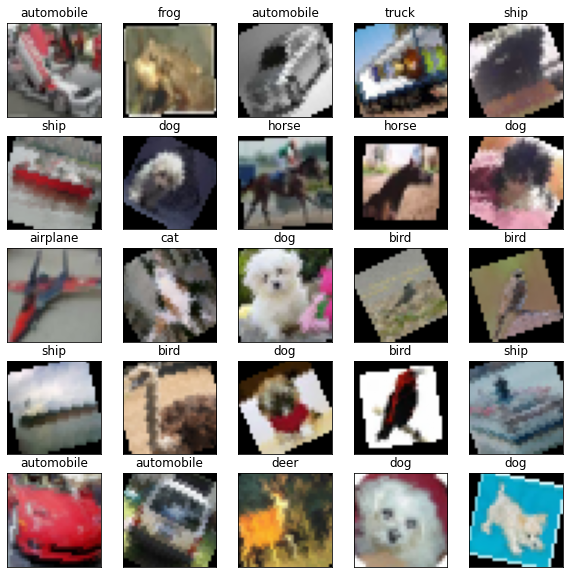

In [3]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.RandomAffine([-30, 30], scale=(0.8, 1.2)),  # 回転とリサイズ
                                transforms.ToTensor()])
cifar10_data = CIFAR10(root="./data",
                       train=False,download=True,
                       transform=transform)
cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer",
                            "dog", "frog", "horse", "ship", "truck"])
print("データの数:", len(cifar10_data))

n_image = 25  # 表示する画像の数
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)
dataiter = iter(cifar10_loader)  # イテレータ
images, labels = dataiter.next()  # 最初のバッチを取り出す #バッチを取り出す際に元の画像に対してランダムに加えられます。

plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(n_image):
    plt.subplot(5,5,i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))  # チャンネルを一番後ろに
    label = cifar10_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

## データの前処理
ここからCNNを実装します。  
データ拡張として、回転とリサイズ、および左右反転を行います。  
また、学習が効率的になるように入力の平均値を0、標準偏差を1にします（標準化）。  
DataLoaderは、訓練データ、テストデータそれぞれで設定しますが、テストデータにはミニバッチ法を適用しないのでバッチサイズは元データのサンプル数にします。

In [4]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2))  # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転 # (p=0.5)：50%の確率で左右反転を行う
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に # RGBそれぞれに対して設定
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## モデルの構築
`nn.Module`モジュールを継承したクラスとして、モデルを構築します。  
今回は、過学習を抑制するためにドロップアウトを導入します。  

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, ストライド）
        self.conv2 = nn.Conv2d(6, 16, 5) # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.fc1 = nn.Linear(16*5*5, 256)  # 全結合層 #5×5のサイズの画像が16枚 # 256は全結合層のニューロンの数
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率) # ニューロンが無効にされる確率が0.5
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #一度畳み込みを行った後に、reluの活性化関数に入れてプーリングを行う。
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  
今回は、評価時にミニバッチ法は使わず、テストデータ全体を使って一度に誤差を計算します。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。


In [6]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
x_test, t_test = iter(test_loader).next() # テストデータを取り出す
x_test, t_test = x_test.cuda(), t_test.cuda() # GPU対応
for i in range(20):  # 20エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t) # 損失の値を計算
        loss_train += loss.item() # 累積
        optimizer.zero_grad() # 勾配をリセット
        loss.backward() # 逆伝播を行って勾配を計算
        optimizer.step() # パラメータの更新
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    y_test = net(x_test)
    loss_test = loss_fnc(y_test, t_test).item()
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.8121102607768516 Loss_Test: 1.5416836738586426
Epoch: 1 Loss_Train: 1.5820920235665559 Loss_Test: 1.4657682180404663
Epoch: 2 Loss_Train: 1.498062247662898 Loss_Test: 1.3492074012756348
Epoch: 3 Loss_Train: 1.4392965928367947 Loss_Test: 1.2898818254470825
Epoch: 4 Loss_Train: 1.4057123154173117 Loss_Test: 1.2577065229415894
Epoch: 5 Loss_Train: 1.3758715072556225 Loss_Test: 1.2364295721054077
Epoch: 6 Loss_Train: 1.3601838530177046 Loss_Test: 1.2456040382385254
Epoch: 7 Loss_Train: 1.3377054396187862 Loss_Test: 1.2032928466796875
Epoch: 8 Loss_Train: 1.3132117180263294 Loss_Test: 1.1924649477005005
Epoch: 9 Loss_Train: 1.3027086165707435 Loss_Test: 1.1579951047897339
Epoch: 10 Loss_Train: 1.293292339805447 Loss_Test: 1.1794133186340332
Epoch: 11 Loss_Train: 1.285443023190169 Loss_Test: 1.1304290294647217
Epoch: 12 Loss_Train: 1.2708066881770064 Loss_Test: 1.1581265926361084
Epoch: 13 Loss_Train: 1.2580300568009886 Loss_Test: 1.1553229093551636
Epoch: 14 Loss_Trai

## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

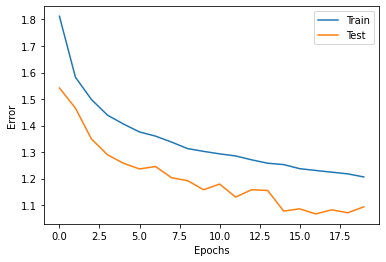

In [7]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [8]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 62.08%


## 訓練済みのモデルを使った予測
訓練済みのモデルを使ってみましょう。  
画像を入力し、モデルが機能していることを確かめます。

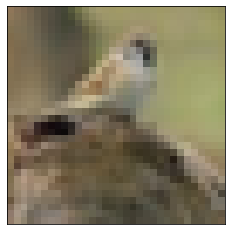

正解: bird 予測結果: bird


In [19]:
cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = dataiter.next()  # サンプルを1つだけ取り出す

plt.imshow(np.transpose(images[0], (1, 2, 0)))  # チャンネルを一番後ろに # 元の画像はRGBそれぞれ1枚ずつの画像。1つの画像に3つの画像(RGB)が入っている変換を行っている。
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

net.eval()  # 評価モード
x, t = images.cuda(), labels.cuda()  # GPU対応
y = net(x)
print("正解:", cifar10_classes[labels[0]],
      "予測結果:", cifar10_classes[y.argmax().item()])